<a href="https://colab.research.google.com/github/jlopetegui98/Literary-Fine-Tuning-of-LLM/blob/main/ClassifierWildeVsMistral/clf_wild_vs_mistral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Classifier Wilde vs Mistral7B (baseline model)

The idea is to train a classifier with texts from Oscar Wilde and texts generated by Mistral7B. Once the model is trained, it should be able to discriminate correctly between texts from both sources. The hypothesis of our work is that after fine tuning the model, we could be able to cheat the classifier.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -U simpletransformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.7/250.7 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 47.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 81.6 

In [9]:
from pandas import DataFrame
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from simpletransformers.classification import ClassificationModel
import torch
import json

In [43]:
# data paths
dir_data = f'./drive/MyDrive/DL-ENS/dataset'
authors_paths = [f'{dir_data}/wilde_complete.txt']
mistral_gen_texts = f'{dir_data}/dataset_mistral7B_gen_texts.json'
authors_names = ["Wilde", "Mistral7B"]

In [44]:
# function to read the texts of an specific author
def read_texts(path: str, label, len_to_read =None, max_length = 350):
    text = ''
    with open(path, 'r+') as fd:
      text = fd.read()
      if len_to_read != None:
        text = text[:len_to_read]
    text_splited = text.split()
    dt = {'text': [], 'label': []}
    for i in range(0,len(text_splited),max_length):
      text = ' '.join(text_splited[i:min(i+max_length, len(text_splited))])
      dt['text'].append(text)
      dt['label'].append(label)
    return dt

In [61]:
# get wilde texts
dt = {'text': [], 'label': []}
for i,path in enumerate(authors_paths):
  dt_i = read_texts(path,i)
  dt['text'].extend(dt_i['text'])
  dt['label'].extend(dt_i['label'])

In [62]:
# get mistral generated texts
with open(mistral_gen_texts, 'r+') as fd:
  mistral_texts = json.load(fd)

# clean texts
patt = r'\[INST]|\[\/INST]|\<s>|\</s>|This are the first lines of a work of fiction. Continue it.'
mistral_texts_cl = [re.sub(patt, '', x) for x in mistral_texts['texts']]
dt['text'].extend(mistral_texts_cl)
dt['label'].extend([1 for _ in range(len(mistral_texts_cl))])

In [63]:
mistral_texts_cl[0]

'  Doug stuck his hand in the box and immediately pulled it out. "Ow," he said. He licked the side of his index finger as if it had honey on it. (Continue to write about who Doug is, where he is, and what is in the box ... )  Doug was a young man in his mid-twenties, with short brown hair and a scruffy beard that only added to his rugged charm. He was standing in a dimly lit room, the type of room that seemed to exude an aura of mystery and danger. The box he had just pulled out of seemed to be made of a rich, dark wood, with intricate carvings that hinted at its being an ancient artifact.\n\nAs he continued to lick his finger, he noticed that the honey he had tasted earlier in the day was still present on the edges of his tongue. It was a peculiar sensation, as though the box had some sort of magical properties that allowed it to imbue objects inside it with unique characteristics.\n\nCurious about what he had just discovered, Doug decided to turn the box over and examine its undersid

In [64]:
# convert the dataset to DataFrame
dt = DataFrame.from_dict(dt)
dt.head()

,text,label
0,SOME CRUELTIES OF PRISON LIFE. THE EDITOR OF T...,0
1,"of centralisation, of officialism, and of irre...",0
2,"warders, not unkindly men, were talking to him...",0
3,for the Prevention of Cruelty to Children woul...,0
4,"night, in a lonely dimly-lit cell, and is prey...",0


In [65]:
dt_train, dt_test = train_test_split(dt, test_size=0.2, random_state=42, shuffle=True)

In [66]:
dt_train.head()

,text,label
1364,"of society, and loved by society in return. Wh...",0
1210,"at life; and one great artist, Flaubert, who i...",0
3014,She was running faster than she thought poss...,1
1226,"could learn handicrafts, and be made industrio...",0
7,to have this done. The way that children are t...,0


In [67]:
dt_test.head()

,text,label
789,"melancholy meal, as hardly any one spoke, and ...",0
257,which the artists would be surrounded and in w...,0
807,that his so-called forgeries were merely the r...,0
2499,momentary separation from anyone to whom one h...,0
1868,"Hurra! Sight never to see again, A prentice De...",0


array([[<Axes: title={'center': 'label'}>]], dtype=object)

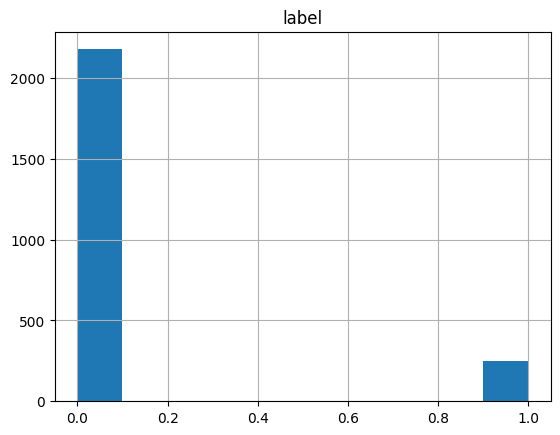

In [68]:
dt_train.hist()

array([[<Axes: title={'center': 'label'}>]], dtype=object)

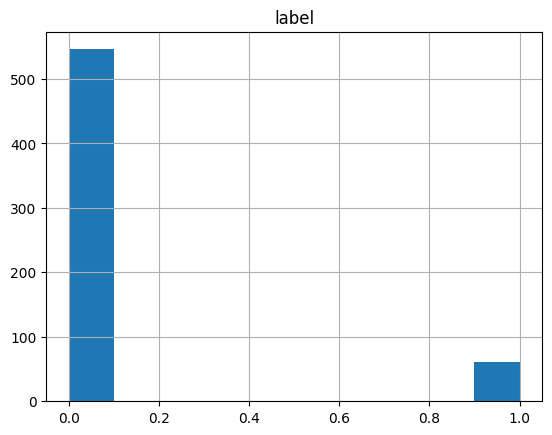

In [69]:
dt_test.hist()

In [70]:
# define model for classifier and initial weights
model_name = 'bert'
model_weights =  'bert-base-cased'

In [71]:
model = ClassificationModel(model_name, model_weights, num_labels=2, weight = [1 - sum(dt_train['label'])/len(dt_train['label']), sum(dt_train['label'])/len(dt_train['label'])], args={'reprocess_input_data': True, 'overwrite_output_dir': True,  'num_train_epochs' : 5}, use_cuda=True)
model.train_model(dt_train)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:611: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/2426 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/304 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Running Epoch 1 of 5:   0%|          | 0/304 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/304 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/304 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/304 [00:00<?, ?it/s]

(1520, 0.015899196917779305)

In [72]:
predictions, raw_out = model.predict(list(dt_test['text']))

  0%|          | 0/607 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

In [73]:
print(classification_report(dt_test['label'], predictions, target_names = authors_names))

              precision    recall  f1-score   support

       Wilde       1.00      1.00      1.00       546
   Mistral7B       1.00      1.00      1.00        61

    accuracy                           1.00       607
   macro avg       1.00      1.00      1.00       607
weighted avg       1.00      1.00      1.00       607



In [74]:
# save model to drive
model_save_name = 'BertClassifier(BERTAA)_wilde_vs_mistral7Bd.pt'
path = f"./drive/My Drive/DL-ENS/{model_save_name}"
torch.save(model, path)